#### Libraries Imported and Setup

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 3090


#### Model Architecture

##### Vision Transformer Model

In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :- 
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary 
    classification token and used to optimize the transformer model by applying Cross-Entropy 
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    
    Args:
        patch_size: Length of square patch size 
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)
    
    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet Models

In [10]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [11]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [12]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [13]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [14]:
def ResNet34(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [15]:
def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading Functions

In [16]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [17]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR10 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation Functions

In [18]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 256
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 100 # All sequences must be less than 1000 including class token
embed_dim = 512
classes = 100
layers = 12
channels = 3
resnet_features_channels = 64
heads = 16
epochs = 100

In [19]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence 
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [20]:
def evaluation(model, dataloader, criterion, resnet_features=None):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)
    
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

#### Model Initialization

Run either one the following subcells according to the models selected to train and test

##### Model - Vision Transformer

Recommended Values for the following Architecture

- patch_size = 4
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 3
- heads = 16

In [22]:
# Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

resnet_features = None

In [23]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

15994634

Recommended Values for the following Architecture

- patch_size = 7
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 64 (Resnet Features Channels)
- heads = 16

In [21]:
# Hybrid Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=resnet_features_channels,
    heads=heads).to(device)

resnet_features = ResNetFeatures().to(device).eval()

In [22]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

16517476

##### Model - ResNet50 or ResNet34


Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet34 Architecture

model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet50 Architecture

model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

#### Model Training and Evaluation

##### CIFAR10 Dataset

In [24]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './data/' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.19it/s]


Epoch : 1 - acc: 0.2471 - loss : 1.9869



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.99it/s]


test acc: 0.3288 - test loss : 1.9843



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.43it/s]


Epoch : 2 - acc: 0.3816 - loss : 1.6522



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.97it/s]


test acc: 0.3893 - test loss : 1.8273



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.35it/s]


Epoch : 3 - acc: 0.4293 - loss : 1.5503



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.60it/s]


test acc: 0.4344 - test loss : 1.6778



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.37it/s]


Epoch : 4 - acc: 0.4649 - loss : 1.4639



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.72it/s]


test acc: 0.4696 - test loss : 1.5732



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.23it/s]


Epoch : 5 - acc: 0.4886 - loss : 1.4218



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 50.13it/s]


test acc: 0.4616 - test loss : 1.7029



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.05it/s]


Epoch : 6 - acc: 0.4951 - loss : 1.4038



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.53it/s]


test acc: 0.4245 - test loss : 1.8126



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.31it/s]


Epoch : 7 - acc: 0.5153 - loss : 1.3514



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.40it/s]


test acc: 0.4800 - test loss : 1.6998



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.33it/s]


Epoch : 8 - acc: 0.5198 - loss : 1.3380



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.27it/s]


test acc: 0.4826 - test loss : 1.6663



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.26it/s]


Epoch : 9 - acc: 0.5332 - loss : 1.3029



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.99it/s]


test acc: 0.4969 - test loss : 1.5488



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.32it/s]


Epoch : 10 - acc: 0.5426 - loss : 1.2748



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.08it/s]


test acc: 0.4973 - test loss : 1.5661



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.44it/s]


Epoch : 11 - acc: 0.5525 - loss : 1.2516



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.20it/s]


test acc: 0.5097 - test loss : 1.5053



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.12it/s]


Epoch : 12 - acc: 0.5598 - loss : 1.2360



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.23it/s]


test acc: 0.4853 - test loss : 1.6500



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.13it/s]


Epoch : 13 - acc: 0.5706 - loss : 1.2002



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.42it/s]


test acc: 0.5000 - test loss : 1.5917



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.34it/s]


Epoch : 14 - acc: 0.5790 - loss : 1.1880



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.36it/s]


test acc: 0.5127 - test loss : 1.6228



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.50it/s]


Epoch : 15 - acc: 0.5828 - loss : 1.1723



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.20it/s]


test acc: 0.5323 - test loss : 1.4455



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.15it/s]


Epoch : 16 - acc: 0.5869 - loss : 1.1621



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.59it/s]


test acc: 0.5277 - test loss : 1.5151



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.30it/s]


Epoch : 17 - acc: 0.5978 - loss : 1.1416



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.04it/s]


test acc: 0.5346 - test loss : 1.4980



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.34it/s]


Epoch : 18 - acc: 0.6026 - loss : 1.1248



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.53it/s]


test acc: 0.5458 - test loss : 1.4323



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.23it/s]


Epoch : 19 - acc: 0.6072 - loss : 1.1103



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.12it/s]


test acc: 0.5588 - test loss : 1.3593



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.24it/s]


Epoch : 20 - acc: 0.6070 - loss : 1.1071



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.10it/s]


test acc: 0.5232 - test loss : 1.5616



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.31it/s]


Epoch : 21 - acc: 0.6193 - loss : 1.0822



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.42it/s]


test acc: 0.5354 - test loss : 1.4682



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.21it/s]


Epoch : 22 - acc: 0.6209 - loss : 1.0791



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.30it/s]


test acc: 0.5440 - test loss : 1.4379



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.20it/s]


Epoch : 23 - acc: 0.6211 - loss : 1.0689



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.21it/s]


test acc: 0.5429 - test loss : 1.4686



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.22it/s]


Epoch : 24 - acc: 0.6220 - loss : 1.0653



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.41it/s]


test acc: 0.5483 - test loss : 1.4554



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.45it/s]


Epoch : 25 - acc: 0.6294 - loss : 1.0508



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.24it/s]


test acc: 0.5454 - test loss : 1.4528



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.47it/s]


Epoch : 26 - acc: 0.6333 - loss : 1.0454



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.53it/s]


test acc: 0.5384 - test loss : 1.5029



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.36it/s]


Epoch : 27 - acc: 0.6368 - loss : 1.0263



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.54it/s]


test acc: 0.5610 - test loss : 1.4215



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.18it/s]


Epoch : 28 - acc: 0.6404 - loss : 1.0201



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.70it/s]


test acc: 0.5473 - test loss : 1.4524



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.32it/s]


Epoch : 29 - acc: 0.6431 - loss : 1.0168



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.69it/s]


test acc: 0.5426 - test loss : 1.5337



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.43it/s]


Epoch : 30 - acc: 0.6487 - loss : 0.9927



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.31it/s]


test acc: 0.5806 - test loss : 1.2892



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.18it/s]


Epoch : 31 - acc: 0.6467 - loss : 0.9971



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.35it/s]


test acc: 0.5567 - test loss : 1.4590



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.31it/s]


Epoch : 32 - acc: 0.6514 - loss : 0.9870



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.49it/s]


test acc: 0.5646 - test loss : 1.4314



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.15it/s]


Epoch : 33 - acc: 0.6547 - loss : 0.9823



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.00it/s]


test acc: 0.6057 - test loss : 1.2171



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.27it/s]


Epoch : 34 - acc: 0.6606 - loss : 0.9647



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.63it/s]


test acc: 0.5953 - test loss : 1.2756



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.48it/s]


Epoch : 35 - acc: 0.6598 - loss : 0.9661



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.06it/s]


test acc: 0.5626 - test loss : 1.4149



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.33it/s]


Epoch : 36 - acc: 0.6617 - loss : 0.9654



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.99it/s]


test acc: 0.5818 - test loss : 1.3224



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.23it/s]


Epoch : 37 - acc: 0.6640 - loss : 0.9559



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.53it/s]


test acc: 0.5798 - test loss : 1.3612



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.45it/s]


Epoch : 38 - acc: 0.6695 - loss : 0.9375



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.83it/s]


test acc: 0.5949 - test loss : 1.3193



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.36it/s]


Epoch : 39 - acc: 0.6697 - loss : 0.9341



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.79it/s]


test acc: 0.5637 - test loss : 1.4405



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.26it/s]


Epoch : 40 - acc: 0.6738 - loss : 0.9306



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.42it/s]


test acc: 0.5767 - test loss : 1.3970



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.25it/s]


Epoch : 41 - acc: 0.6767 - loss : 0.9225



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.59it/s]


test acc: 0.5979 - test loss : 1.2575



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.40it/s]


Epoch : 42 - acc: 0.6750 - loss : 0.9176



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.00it/s]


test acc: 0.5692 - test loss : 1.3725



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.29it/s]


Epoch : 43 - acc: 0.6785 - loss : 0.9105



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.06it/s]


test acc: 0.5847 - test loss : 1.3712



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.39it/s]


Epoch : 44 - acc: 0.6852 - loss : 0.8940



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.89it/s]


test acc: 0.5955 - test loss : 1.2592



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.31it/s]


Epoch : 45 - acc: 0.6829 - loss : 0.9026



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.83it/s]


test acc: 0.5956 - test loss : 1.3058



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.20it/s]


Epoch : 46 - acc: 0.6841 - loss : 0.8960



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.15it/s]


test acc: 0.5757 - test loss : 1.3582



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.31it/s]


Epoch : 47 - acc: 0.6920 - loss : 0.8787



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.18it/s]


test acc: 0.5782 - test loss : 1.4151



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.28it/s]


Epoch : 48 - acc: 0.6896 - loss : 0.8809



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.24it/s]


test acc: 0.5931 - test loss : 1.3206



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.17it/s]


Epoch : 49 - acc: 0.6936 - loss : 0.8676



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.00it/s]


test acc: 0.6008 - test loss : 1.2526



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.35it/s]


Epoch : 50 - acc: 0.6931 - loss : 0.8730



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.79it/s]


test acc: 0.5950 - test loss : 1.3006



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.42it/s]


Epoch : 51 - acc: 0.6928 - loss : 0.8697



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.79it/s]


test acc: 0.6021 - test loss : 1.2954



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.02it/s]


Epoch : 52 - acc: 0.6981 - loss : 0.8583



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.97it/s]


test acc: 0.5761 - test loss : 1.3751



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.29it/s]


Epoch : 53 - acc: 0.6965 - loss : 0.8632



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.38it/s]


test acc: 0.6057 - test loss : 1.2707



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.10it/s]


Epoch : 54 - acc: 0.7002 - loss : 0.8491



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.28it/s]


test acc: 0.5782 - test loss : 1.3369



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.39it/s]


Epoch : 55 - acc: 0.7019 - loss : 0.8456



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.75it/s]


test acc: 0.5997 - test loss : 1.2971



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.10it/s]


Epoch : 56 - acc: 0.7070 - loss : 0.8313



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.06it/s]


test acc: 0.5896 - test loss : 1.2645



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.26it/s]


Epoch : 57 - acc: 0.7057 - loss : 0.8437



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.73it/s]


test acc: 0.6214 - test loss : 1.1998



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.08it/s]


Epoch : 58 - acc: 0.7083 - loss : 0.8268



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.76it/s]


test acc: 0.6040 - test loss : 1.2868



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.11it/s]


Epoch : 59 - acc: 0.7122 - loss : 0.8160



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.45it/s]


test acc: 0.5861 - test loss : 1.3911



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.32it/s]


Epoch : 60 - acc: 0.7118 - loss : 0.8176



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.16it/s]


test acc: 0.6104 - test loss : 1.2315



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.20it/s]


Epoch : 61 - acc: 0.7091 - loss : 0.8234



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.10it/s]


test acc: 0.5771 - test loss : 1.3960



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.54it/s]


Epoch : 62 - acc: 0.7156 - loss : 0.8097



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.62it/s]


test acc: 0.6001 - test loss : 1.2654



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.32it/s]


Epoch : 63 - acc: 0.7150 - loss : 0.8137



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.82it/s]


test acc: 0.6113 - test loss : 1.2426



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.12it/s]


Epoch : 64 - acc: 0.7180 - loss : 0.8048



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.33it/s]


test acc: 0.6312 - test loss : 1.1567



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.30it/s]


Epoch : 65 - acc: 0.7192 - loss : 0.8009



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.78it/s]


test acc: 0.6166 - test loss : 1.2662



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.42it/s]


Epoch : 66 - acc: 0.7224 - loss : 0.7888



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.03it/s]


test acc: 0.6266 - test loss : 1.2159



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.28it/s]


Epoch : 67 - acc: 0.7219 - loss : 0.7913



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.97it/s]


test acc: 0.5979 - test loss : 1.3216



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.19it/s]


Epoch : 68 - acc: 0.7252 - loss : 0.7813



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.08it/s]


test acc: 0.6208 - test loss : 1.2105



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.33it/s]


Epoch : 69 - acc: 0.7237 - loss : 0.7873



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.17it/s]


test acc: 0.6079 - test loss : 1.3149



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.41it/s]


Epoch : 70 - acc: 0.7264 - loss : 0.7772



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.41it/s]


test acc: 0.6148 - test loss : 1.2705



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.41it/s]


Epoch : 71 - acc: 0.7282 - loss : 0.7664



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.02it/s]


test acc: 0.5899 - test loss : 1.4052



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.17it/s]


Epoch : 72 - acc: 0.7261 - loss : 0.7676



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.09it/s]


test acc: 0.6179 - test loss : 1.2491



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.28it/s]


Epoch : 73 - acc: 0.7305 - loss : 0.7672



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.04it/s]


test acc: 0.6225 - test loss : 1.2414



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.36it/s]


Epoch : 74 - acc: 0.7315 - loss : 0.7630



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.35it/s]


test acc: 0.6326 - test loss : 1.1819



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.43it/s]


Epoch : 75 - acc: 0.7355 - loss : 0.7513



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.01it/s]


test acc: 0.6364 - test loss : 1.1865



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.42it/s]


Epoch : 76 - acc: 0.7331 - loss : 0.7570



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.18it/s]


test acc: 0.6355 - test loss : 1.1942



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.50it/s]


Epoch : 77 - acc: 0.7376 - loss : 0.7499



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.99it/s]


test acc: 0.6098 - test loss : 1.2732



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.27it/s]


Epoch : 78 - acc: 0.7359 - loss : 0.7452



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.58it/s]


test acc: 0.6201 - test loss : 1.1811



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.37it/s]


Epoch : 79 - acc: 0.7392 - loss : 0.7415



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.65it/s]


test acc: 0.6196 - test loss : 1.2097



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.26it/s]


Epoch : 80 - acc: 0.7394 - loss : 0.7390



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.10it/s]


test acc: 0.6307 - test loss : 1.1772



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.35it/s]


Epoch : 81 - acc: 0.7446 - loss : 0.7238



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.54it/s]


test acc: 0.6276 - test loss : 1.2052



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.23it/s]


Epoch : 82 - acc: 0.7449 - loss : 0.7275



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.40it/s]


test acc: 0.6436 - test loss : 1.1204



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.14it/s]


Epoch : 83 - acc: 0.7406 - loss : 0.7292



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.77it/s]


test acc: 0.6205 - test loss : 1.2577



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.33it/s]


Epoch : 84 - acc: 0.7469 - loss : 0.7208



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.16it/s]


test acc: 0.6343 - test loss : 1.1784



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.24it/s]


Epoch : 85 - acc: 0.7454 - loss : 0.7219



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.90it/s]


test acc: 0.6359 - test loss : 1.1564



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.18it/s]


Epoch : 86 - acc: 0.7482 - loss : 0.7094



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 44.37it/s]


test acc: 0.6282 - test loss : 1.1960



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.27it/s]


Epoch : 87 - acc: 0.7494 - loss : 0.7158



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.36it/s]


test acc: 0.6271 - test loss : 1.1968



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.29it/s]


Epoch : 88 - acc: 0.7498 - loss : 0.7081



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.88it/s]


test acc: 0.6476 - test loss : 1.1213



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.41it/s]


Epoch : 89 - acc: 0.7505 - loss : 0.7097



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.19it/s]


test acc: 0.6261 - test loss : 1.2078



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.30it/s]


Epoch : 90 - acc: 0.7501 - loss : 0.7057



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.38it/s]


test acc: 0.6410 - test loss : 1.1540



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.06it/s]


Epoch : 91 - acc: 0.7532 - loss : 0.6996



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.18it/s]


test acc: 0.6338 - test loss : 1.1841



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.29it/s]


Epoch : 92 - acc: 0.7550 - loss : 0.6928



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.66it/s]


test acc: 0.6328 - test loss : 1.2270



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.28it/s]


Epoch : 93 - acc: 0.7541 - loss : 0.6979



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.11it/s]


test acc: 0.6345 - test loss : 1.1996



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.25it/s]


Epoch : 94 - acc: 0.7568 - loss : 0.6908



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 46.58it/s]


test acc: 0.6200 - test loss : 1.2274



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.25it/s]


Epoch : 95 - acc: 0.7580 - loss : 0.6893



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 45.84it/s]


test acc: 0.6151 - test loss : 1.3322



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.14it/s]


Epoch : 96 - acc: 0.7633 - loss : 0.6740



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.91it/s]


test acc: 0.6334 - test loss : 1.1931



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.16it/s]


Epoch : 97 - acc: 0.7618 - loss : 0.6776



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.83it/s]


test acc: 0.6173 - test loss : 1.3259



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.29it/s]


Epoch : 98 - acc: 0.7611 - loss : 0.6776



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.36it/s]


test acc: 0.6385 - test loss : 1.1702



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.20it/s]


Epoch : 99 - acc: 0.7629 - loss : 0.6714



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.32it/s]


test acc: 0.6445 - test loss : 1.1807



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.26it/s]


Epoch : 100 - acc: 0.7631 - loss : 0.6746



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.75it/s]


test acc: 0.6388 - test loss : 1.1866



In [26]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

15994634

##### CIFAR100 Dataset

In [ ]:
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './checkpoints/' + model.name + '_CIFAR100_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.30it/s]


Epoch : 1 - acc: 0.0109 - loss : 4.6132



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.35it/s]


test acc: 0.0105 - test loss : 4.6060



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.36it/s]


Epoch : 2 - acc: 0.0093 - loss : 4.6062



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.12it/s]


test acc: 0.0100 - test loss : 4.6059



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.33it/s]


Epoch : 3 - acc: 0.0092 - loss : 4.6058



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 48.36it/s]


test acc: 0.0095 - test loss : 4.6058



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.10it/s]


Epoch : 4 - acc: 0.0099 - loss : 4.6058



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 47.90it/s]


test acc: 0.0104 - test loss : 4.6058



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.60it/s]


Epoch : 5 - acc: 0.0101 - loss : 4.6058



100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 49.09it/s]


test acc: 0.0098 - test loss : 4.6058



100%|█████████████████████████████████████████| 196/196 [00:10<00:00, 19.32it/s]


Epoch : 6 - acc: 0.0096 - loss : 4.6057



 18%|███████▋                                    | 7/40 [00:00<00:01, 30.62it/s]

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

##### Saving accuracy

In [ ]:
import csv

dataset = 'cifar100'
path = './results/'
model_name = 'original_pretrained'

with open(path+'train_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in train_accs:
        wr.writerow([point])
        
        
with open(path+'test_'+dataset+'_'+model_name+'.csv', 'w', newline='\n') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     for point in test_accs:
        wr.writerow([point])

##### Plotting Results

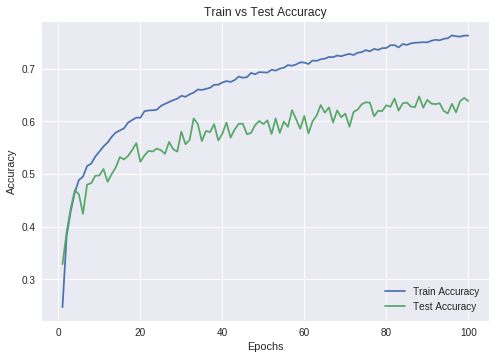

In [26]:
#CIFAR10
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')

In [ ]:
#CIFAR100
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')